In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import regex as re

from nltk.corpus import stopwords
# Need to uncomment the following line in order to download nltk stopwords:
# nltk.download('stopwords')
import spacy
from textacy.extract import keyword_in_context

from collections import Counter

from sklearn.decomposition import NMF, TruncatedSVD

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()

# Import data set:

In [3]:
pd.options.mode.chained_assignment = None

with open('data/dk_asylum_data.json', encoding='utf-8') as inputfile:
    df_full = pd.read_json(inputfile)

# Convert json to csv:
df_full.to_csv('data/dk_asylum_data.csv', encoding='utf-8', index=False)

df_full.shape


(9324, 5)

## Keep cases marked as Unknown Homeland (Ukendt hjemland):

In [4]:
df_ALL = df_full[df_full.country == "Ukendt hjemland"]

# Drop redundant column:
df_ALL.drop('hasText', axis=1, inplace=True)

# Keep column 'text':
df = df_ALL[['text']]

df["text"] = df["text"].astype(str)

df.shape

#df.head()


(192, 1)

## Length of texts

Create a numeric column in order to get a feel about the length of the texts. 

In [5]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,192.0,5016.598958,2045.83413,1104.0,3522.0,4789.0,6148.75,13105.0


## Boxplot:

<AxesSubplot:>

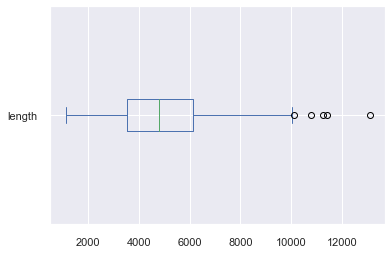

In [6]:
# Box plot:
df['length'].plot(kind='box', vert=False)

## Histogram:

<AxesSubplot:ylabel='Frequency'>

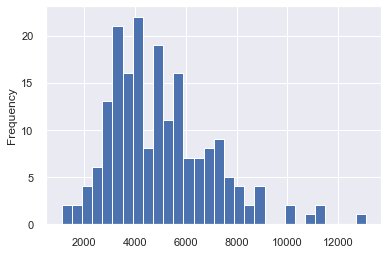

In [7]:
# Histogram:
df['length'].plot(kind='hist', bins=30)


# Create a pipeline:

Below are the steps taken to process the texts.

In [8]:
stopwords_lower = list(map(lambda x: x.lower(), stopwords.words('danish')))

STOPWORDS_DANISH = set(stopwords_lower)

nlp = spacy.load("da_core_news_sm")

PUNCTUATION_TO_REMOVE = '–«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»●·’“”'


def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCTUATION_TO_REMOVE))


def remove_stopwords(tokens):
    """custom function to remove stopwords"""
    return [t for t in tokens if t.lower() not in STOPWORDS_DANISH]


def tokenize(text):
    """the following expression matches tokens consisting of at least one letter (\p{L}), 
    preceded and followed by an arbitrary sequence of alphanumeric characters 
    (\w includes digits, letters, and underscore) and hyphens (-)"""
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)


def drop_single_letter_words(text):
    return [w for w in text if len(w) > 1]


def lemmatize(text):
    """custom function to lemmatize text"""
    doc = nlp(' '.join(text))
    # pos_tagged_text = text.pos
    return [token.lemma_ for token in doc]


# def remove_junk(text):
#     # Creating a spacy object
#     doc = nlp(' '.join(text))
#     # Checking if POS tag is X and printing them
#     for token in doc:
#         if token.pos_ == 'X':
#             print(token.text)
#     # Removing the tokens whose POS tag is junk.
#     clean_doc = [token.text for token in doc if not token.pos_ == 'X']

#     return clean_doc


Steps can be added or removed from the pipeline.

In [9]:
pipeline = [str.lower, remove_punctuation, tokenize,
            drop_single_letter_words, remove_stopwords, lemmatize]


def process(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [10]:
# Apply the process pipeline:
df['tokens'] = df['text'].apply(process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

In [11]:
df.head()

,text,length,tokens,num_tokens
201,Nævnet stadfæstede i november 2021 Udl...,4753,"[nævn, stadfæste, november, udlændingestyrelse...",373
428,Nævnet stadfæstede i juni 2021 Udlændi...,3149,"[nævn, stadfæste, juni, udlændingestyrelse, af...",243
464,Nævnet stadfæstede i juni 2021 Udlændi...,4433,"[nævn, stadfæste, juni, udlændingestyrelse, af...",350
901,Nævnet stadfæstede i december 2020 Udl...,2664,"[nævn, stadfæste, december, udlændingestyrelse...",207
1291,Nævnet hjemviste i juni 2020 Udlænding...,4626,"[nævn, hjemviste, juni, udlændingestyrelse, af...",354


# Frequency analysis:

Here we count the most frequent tokens in the **whole** corpus.


In [12]:
# Transform the counter into a Pandas DataFrame with the following function:

"""
The tokens make up the index of the DataFrame, while the frequency values are stored in a column named freq. 
The rows are sorted so that the most frequent words appear at the head.
The last parameter of count_words defines a minimum frequency of tokens to be included in the result. 
Its default is set to 2 to cut down on tokens occurring only once.
"""

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    # create counter and run through all data
    counter = Counter() 
    df[column].map(update)
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq']) 
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

In [13]:
# See ten most frequent words in the whole corpus:

freq_df = count_words(df) 
freq_df.head(10)

,freq
token,
ansøger,4889
flygtningenævn,1510
kuwait,1453
forklare,1252
oplyse,845
ansøge,838
vide,823
myndighed,817
mandlig,807


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

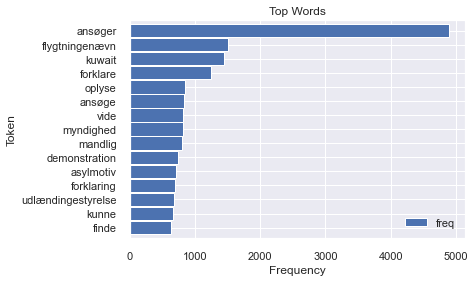

In [14]:
# Plot the results:
ax = freq_df.head(15).plot(kind='barh', width=0.95) 
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# TF-IDF Ranking:

Rank tokens based on their TF-IDF score.

In [15]:
"""
Each token is counted only once per document (counter.update(set(tokens))), 
and the IDF values are computed after counting. 
The parameter min_df serves as a filter for the long tail of infrequent words. 
The result of this function is a DataFrame.
"""

def compute_idf(df, column='tokens', preprocess=None, min_df=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc) 
        counter.update(set(tokens))
        # count tokens
    counter = Counter() 
    df[column].map(update)
        # create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df']) 
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [16]:
# Create a DataFrame containing the IDF values for each token (idf_df):

idf_df = compute_idf(df)

# Both the IDF and the frequency DataFrame have an index consisting of the tokens, 
# we can simply multiply the columns of both DataFrames to calculate the TF-IDF score for the terms:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']


In [17]:
# Sort values based on their score:
freq_df = freq_df.sort_values('tfidf', ascending=False)

# See the top 15:
freq_df.head(15)

,freq,tfidf
token,,
klager,344,1050.889136
ansøger,4889,750.406181
ansøge,838,622.110129
kuwait,1453,523.491342
demonstration,745,449.909360
kvindelig,358,358.281583
ægtefælle,313,347.117041
eritrea,107,307.366993
forklare,1252,299.855953


[Text(0.5, 0, 'Weights'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Top 15 Words based on TF-IDF Ranking')]

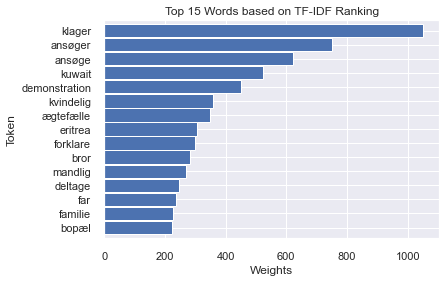

In [18]:
# Plot the results:
ax_tf_idf = freq_df['tfidf'].head(15).plot(kind='barh', width=0.95) 
ax_tf_idf.invert_yaxis()
ax_tf_idf.set(xlabel='Weights', ylabel='Token', title='Top 15 Words based on TF-IDF Ranking')

# Keyword in context (KWIC):

KWIC analysis produces a list of text fragments of equal length showing the left and right context of a keyword.

In [19]:
"""
The function iteratively collects the keyword contexts by applying the add_kwic function to each document with map. 
By default, the function returns a list of tuples of the form (left context, keyword, right context). 
If print_samples is greater than 0, a random sample of the results is printed. 
Sampling is especially useful with lots of documents because the first entries of the list 
would otherwise stem from a single or a very small number of documents.
"""

def kwic(doc_series, keyword, window=35, print_samples=5):
    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True, window_width=window))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples == 0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f'{k} random samples out of {len(kwic_list)} ' +
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0]) + ' ' +
                  sample[1]+' ' +
                  re.sub(r'[\n\t]', ' ', sample[2]))


Bellow we apply KWIC for `stk` keyword found from the frequency analysis and print 10 random context appearances.

The call is made to the original untokenized & unprocessed dataset.

In [20]:
kwic(df['text'], 'stk', print_samples=10)

10 random samples out of 380 contexts for 'stk':
 omfattet af udlændingelovens § 7,  stk . 2. Nævnet har ikke fundet anledni
ende stoffer § 3, stk. 1, jf. § 2,  stk . 4, jf. bekendtgørelse om euforise
udlændingelovens § 7, stk. 1 eller  stk . 2. En ansøgning om humanitær opho
jf. § 19, stk. 2, nr. 1 og § 19 a,  stk . 2, jf. § 26, stk. 1. Udlændingest
dlændingelovens § 7, stk. 1, eller  stk . 2, er opfyldt. Flygtningenævnet s
ingelovens § 11, stk. 2, jf. § 19,  stk . 2, nr. 1 og § 19 a, stk. 2, jf. §
vens § 19, stk. 2, nr. 1, og § 19,  stk . 7, 1. pkt., jf. § 26, stk. 1, ide
i medfør af udlændingelovens §§ 7,  stk . 1 eller 8, stk. 1. Klageren har t
siko for overgreb omfattet af § 7,  stk . 2. Det bemærkes at Flygtningenævn
ølgelse, jf. udlændingelovens § 7,  stk . 1, eller har behov for beskyttels


# N-gram analysis:

In [21]:
"""
Create the bigrams on all tokens but keep only those that do not contain any stop words.
"""

def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)]) 
            if len([t for t in ngram if t in stopwords]) == 0]


Add a column to the dataset containing all 'bigrams'.

Then apply `count_words` in order to determing the 10 most popular ones.

In [22]:
df['bigrams'] = df['text'].apply(process, pipeline=[str.lower, tokenize]).apply(ngrams, n=2, stopwords=STOPWORDS_DANISH)

count_words(df, 'bigrams').head(10)

,freq
token,
mandlige ansøger,502
udlændingestyrelsens afgørelse,398
lagt vægt,282
kvindelige ansøger,280
flygtningenævnet finder,251
asylmotiv henvist,237
udlændingelovens stk,235
ansøgerens forklaring,230
forklaret divergerende,228


# Topic Modelling:

## NMF:

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_text = TfidfVectorizer(stop_words = STOPWORDS_DANISH, min_df = 5, max_df = 0.7)
vectors_text = tfidf_text.fit_transform(df['text'])
vectors_text.shape

(192, 1470)

In [24]:
nmf_text_model = NMF(n_components=10, random_state=42)

W_text_matrix = nmf_text_model.fit_transform(vectors_text)
H_text_matrix = nmf_text_model.components_

def display_topics(model, features, num_top_words=5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # inverts sort order
        print("\nTopic %02d" % topic)
        for i in range(0, num_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], word_vector[largest[i]]*100.0/total))

/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Display topics:

Presenting topics, along with words and percentages with which the words contribute to each of the topic.

In [25]:
display_topics(nmf_text_model, tfidf_text.get_feature_names_out())


Topic 00
 mandlige (6.08)
 ansøger (5.02)
 ansøgerne (4.57)
 kvindelige (2.29)
 ansøgernes (1.77)

Topic 01
 demonstrationer (1.25)
 demonstration (1.15)
 demonstrationen (1.12)
 deltaget (0.95)
 rettigheder (0.92)

Topic 02
 klageren (11.00)
 klagerens (5.27)
 jf (1.60)
 19 (1.31)
 svig (1.30)

Topic 03
 eritrea (7.68)
 sudan (3.50)
 etiopien (1.93)
 tigrinya (1.44)
 eritreiske (1.20)

Topic 04
 mandlige (1.86)
 kvindelige (1.68)
 ansøger (1.65)
 ansøgerne (1.41)
 ansøgers (1.40)

Topic 05
 børn (0.96)
 lægges (0.94)
 søn (0.77)
 familiemedlemmer (0.77)
 bidoonere (0.76)

Topic 06
 brødre (1.52)
 bror (1.46)
 udlænding (1.20)
 far (1.14)
 divergerende (1.12)

Topic 07
 navn (0.81)
 2017 (0.80)
 statsborger (0.76)
 ihjel (0.76)
 ægtefælle (0.72)

Topic 08
 hjemlandet (1.55)
 begyndelsen (1.28)
 individuel (1.20)
 bemærkes (1.13)
 2018 (1.10)

Topic 09
 forklarede (1.79)
 bopælen (1.21)
 far (1.08)
 kom (1.01)
 tog (0.99)


See how many documents could be assigned mainly to each topic: 

- Calculate using the document - topic matrix and summing the individual topic contributions over all documents.

Normalizing them with the total sum and multiplying by 100 gives a percentage value:

In [26]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([13.14753303, 12.42013457,  6.14324739,  6.3761418 ,  8.12267854,
        8.30309525, 12.12598638, 15.16226955,  7.90400961, 10.29490388])

## Latent Semantic Analysis/Indexing:

Similar analysis to NMF but using a different algorithm: Singular Value Decomposition (SVD).

In [27]:
svd_model = TruncatedSVD(n_components=10, random_state=42)

W_svd_text_matrix = svd_model.fit_transform(vectors_text)
H_svd_text_matrix = svd_model.components_

In [28]:
display_topics(svd_model, tfidf_text.get_feature_names_out())


Topic 00
 mandlige (1.51)
 ansøger (1.35)
 ansøgerne (1.18)
 kvindelige (0.70)
 ansøgers (0.55)

Topic 01
 mandlige (-3.24)
 ansøger (-2.51)
 ansøgerne (-2.34)
 kvindelige (-1.36)
 ansøgers (-1.08)

Topic 02
 klageren (-79.60)
 klagerens (-38.18)
 jf (-10.63)
 svig (-9.47)
 19 (-9.33)

Topic 03
 eritrea (41.21)
 sudan (19.04)
 etiopien (10.51)
 tigrinya (7.74)
 år (7.36)

Topic 04
 bar (52.49)
 oplysnings (41.49)
 motivsamtalen (40.14)
 videre (36.77)
 resultat (36.10)

Topic 05
 eritrea (9.94)
 lægges (9.08)
 demonstrationen (7.89)
 børn (7.19)
 hvert (6.75)

Topic 06
 bror (-46.76)
 brødre (-45.90)
 udlænding (-43.03)
 ansøgerne (-40.08)
 følger (-39.35)

Topic 07
 ægtefælle (8.26)
 2017 (6.67)
 danmark (6.62)
 oplyste (6.46)
 navn (6.44)

Topic 08
 hjemlandet (-44.72)
 individuel (-31.39)
 konkret (-30.32)
 efteråret (-30.27)
 bemærkes (-28.84)

Topic 09
 far (25.61)
 bopælen (20.47)
 hjemlandet (15.80)
 begyndelsen (13.66)
 libyen (13.64)


The results are pretty much the same as with NMF. 

The main difference is that SVD allows for negative values. This means that contributions of individual words can be negative.

SVD presents words in documents which "reject" the corresponding topic.